In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#list of libraries
from datetime import date
import praw
import pandas as pd
import datetime as dt
import seaborn as sns
pd.set_option('display.max_rows', 500)
from bs4 import BeautifulSoup
import requests
import time

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Analysis: Inmode

In [3]:
ticker_symbol = 'INMD'
today = date.today()

print("Ticker Symbol: " + ticker_symbol)
print("Last Update Date:", today)

Ticker Symbol: INMD
Last Update Date: 2021-08-31


## 1. Business Overview

In [4]:
stock = ticker_symbol
r = requests.get("https://ca.finance.yahoo.com/quote/" + stock + "/profile?p=" + stock).text

time.sleep(2)

soup = BeautifulSoup(r,"html.parser")

#print(soup.prettify())

#soup.find_all("tbody")

ps = soup.find_all('p')

if len(ps)<= 4:
    # try from the Toronto stock exchange
    r = requests.get("https://ca.finance.yahoo.com/quote/" + stock + ".TO" + "/profile?p=" + stock + ".TO").text
    soup = BeautifulSoup(r,"html.parser")
    ps = soup.find_all('p')

    # try from another Stock exchange
    if len(ps) <= 4:
            r = requests.get("https://ca.finance.yahoo.com/quote/" + stock + ".V" + "/profile?p=" + stock + ".V").text
            soup = BeautifulSoup(r,"html.parser")
            ps = soup.find_all('p')

print(color.BOLD  + "From Yahoo Finance: " + str(stock) + color.END)
print(" ")

for p in ps[1:]:
    print(p.get_text())
    print(" ")

From Yahoo Finance: INMD
 
Our engineers are working quickly to resolve the issue.
 


## 2. Discounted Cash Flow Model 

Steps:
1. Estimate the cashflow for the next 5-10 years (may have to use revenue projections + net margin estimations) 
    1.1 Opportunity to use analysts estimates as upper and lower boundaries or previous net margin and revenue growths
2. Discount the cashflows to their present value using 10%
3. Assume a perpetuity growth rate (usually 3-3.5%)
4. Add the discounted value of cashflows to the terminal value (value obtained from the perpetuity rate) to obtain a market capitalization for the company
5. Come up with a fair price by dividing by the number of shares outstanding (take into account future dilution)
6. Come up with an adjusted fair price by substracting the company's net debt from the market capitalization (net debt = total debt - cash and cash equivalent). If the net debt is higher than 0, then put nothing.

In [5]:
print("http://financials.morningstar.com/ratios/r.html?t=inmd&region=usa&culture=en-US&ownerCountry=USA")

http://financials.morningstar.com/ratios/r.html?t=inmd&region=usa&culture=en-US&ownerCountry=USA


In [6]:
a = ['14	37	62	79'] #copy and paste from morning star

In [7]:
def cleanCashFlowStringFromMorningStar(cash_flow_string, multiplier, start_year, metric):
    temp = [] 
    cash_flows = []
    for i in cash_flow_string:
        temp.append(i.split('\t'))

    for i in temp[0]:
        cash_flows.append(int(i)*multiplier)
        
    df = pd.DataFrame(cash_flows, [i+start_year for i in range(0,len(cash_flows))], columns=[metric])
    
    return df

In [8]:
a = cleanCashFlowStringFromMorningStar(a, 1000000, 2017, 'cash_flow')
print(a)

      cash_flow
2017   14000000
2018   37000000
2019   62000000
2020   79000000


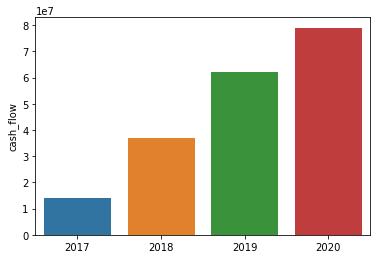

In [9]:
import seaborn as sns
#sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=a.index, y="cash_flow", data=a)

In [10]:
import datetime
now = datetime.datetime.now()
current_year = now.year

# takes as an argument the cashflow and makes projections based on the
def discountedCashFlowModel(cash_flow, shares_outstanding, past_timeline, future_timeline, discount_rate, perpetuity_rate):
    """
    cash_flow: list of cash flow extracted from morning star
    shares_outstanding: estimated number of shares outstanding at the end of the timeline
    past_timeline: number of years that you want to take into account to project future growth
    future_timeline: number of years in the future that we want to project
    discount_rate: usually 10%
    perpetuity_rate: usually 3%  
    
    """
    
    #computing the average growth rate
    growth_rate = a.pct_change().values[len(a)-past_timeline:].mean()+1
    print("The growth rate that will be used " + str(round(float(growth_rate),2)))
    print(" ")
    
    
    #cash flow at horizon
    cash_flow_at_horizon = a[-1:].values[0][0] #latest cashflow
    list_of_discounted_cash_flow = 0
    list_of_cash_flow  = 0
    for i in range(0, future_timeline):
        cash_flow_at_horizon = cash_flow_at_horizon*growth_rate
        discounted_cash_flow_at_horizon = cash_flow_at_horizon/((1+discount_rate)**(i+1))
        #print(discounted_cash_flow_at_horizon)
        #print(" Cash flow in " + str(i+1+current_year) + " is : " + str("${:,.2f}".format(int(cash_flow_at_horizon))+"$"))
        print(" Discounted Cash flow in " + str(i+1+current_year) + " is : " + str("${:,.2f}".format(int(discounted_cash_flow_at_horizon))+"$"))

        
        list_of_cash_flow = list_of_cash_flow + cash_flow_at_horizon
        list_of_discounted_cash_flow = list_of_discounted_cash_flow + discounted_cash_flow_at_horizon
        #print(cash_flow_at_horizon)
    
        
    #cashflow at perpetuity
    terminal_value = (cash_flow_at_horizon*(1+perpetuity_rate)/(discount_rate-perpetuity_rate))
    discounted_terminal_value = terminal_value/((1+discount_rate)**(future_timeline))
    print(" ")
    #print(" Discounted Terminal Value in " + str(i+1+current_year) + " is : " + str("${:,.2f}".format(int(discounted_terminal_value))+"$"))
    #print(discounted_terminal_value)
    
    market_cap = discounted_terminal_value+list_of_discounted_cash_flow
    print(" ")
    #print(" Market Cap in " + str(future_timeline+current_year) + " is : " + str("${:,.2f}".format(int(market_cap))+"$"))
    
    fair_price_now = market_cap/shares_outstanding
    price_at_horizon = (list_of_cash_flow + terminal_value)/shares_outstanding
    
    print(" Fair price as of Today " + str(int(fair_price_now)) + "$ ")
    
    print(" Share price at Horizon " + str(int(price_at_horizon)) + "$ ")

                      


In [11]:
discountedCashFlowModel(a, 45000000 , 1, 4, 0.07, 0.035)

The growth rate that will be used 1.27
 
 Discounted Cash flow in 2022 is : $94,075,972.00$
 Discounted Cash flow in 2023 is : $112,028,969.00$
 Discounted Cash flow in 2024 is : $133,408,027.00$
 Discounted Cash flow in 2025 is : $158,866,960.00$
 
 
 Fair price as of Today 115$ 
 Share price at Horizon 150$ 


## 3. P/E Ratio Model

Steps:
1. Come up with some estimations of the earnings for the next 5-10 years (may use revenue projections + a net margin)
2. Assume a P/E ratio 
3. Get a market capitalizatoin
4. Divide by the number of outstanding shares
5. discount the share price by a factor of 10% and you get the adjusted fair price today
6. Take into account a margin of safety

      Earnings
2017   9000000
2018  22000000
2019  61000000
2020  75000000


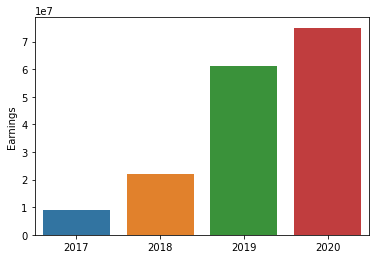

In [12]:
a = ['9	22	61	75'] #copy and paste from morning star
outstanding_shares_at_horizon = 45000000

# cash flow strings, multiplier, starting year
a = cleanCashFlowStringFromMorningStar(a, 1000000, 2017, 'Earnings')
print(a)

import seaborn as sns
#sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=a.index, y="Earnings", data=a)

In [13]:
#computing the average growth rate
growth_rate = a.pct_change().values[len(a)-1].mean()+1
print("The growth rate that will be used " + str(round(float(growth_rate),2)))


The growth rate that will be used 1.23


In [14]:
future_timeline = 5
discount_rate = 0.07
pe_at_horizon = 38

In [15]:
earnings_at_horizon = a[-1:].values[0][0] #latest cashflow
list_of_discounted_earnings = 0
list_of_earnings  = 0
for i in range(0, future_timeline):
    earnings_at_horizon = earnings_at_horizon*growth_rate
    discounted_earnings_at_horizon = earnings_at_horizon/((1+discount_rate)**(i+1))
    #print(discounted_cash_flow_at_horizon)
    #print(" Cash flow in " + str(i+1+current_year) + " is : " + str("${:,.2f}".format(int(cash_flow_at_horizon))+"$"))
    print(" Discounted Cash flow in " + str(i+1+current_year) + " is : " + str("${:,.2f}".format(int(discounted_earnings_at_horizon))+"$"))


    list_of_earnings = list_of_earnings + earnings_at_horizon
    list_of_discounted_earnings = list_of_discounted_earnings + discounted_earnings_at_horizon
    #print(cash_flow_at_horizon)
    
fair_price_now = discounted_earnings_at_horizon/outstanding_shares_at_horizon * pe_at_horizon
print(" ")
print("The fair price today is " + str(int(fair_price_now)) + "$")

 Discounted Cash flow in 2022 is : $86,180,481.00$
 Discounted Cash flow in 2023 is : $99,027,670.00$
 Discounted Cash flow in 2024 is : $113,790,030.00$
 Discounted Cash flow in 2025 is : $130,753,061.00$
 Discounted Cash flow in 2026 is : $150,244,823.00$
 
The fair price today is 126$


## 4. Position

In [45]:
print("Average purchase price: 95USD")

Average purchase price: 95USD
